In [1]:
import numpy as np

### 시그모이드(sigmoid) : $σ(z) = 1/1+e^{-z}$
- 값이 커지더라도 결국엔 1에 수렴하며 항상 0과 1사이의 값을 가진다

In [3]:
z = np.arange(-10, 10, 0.01)
g = 1 / (1+np.exp(-z))

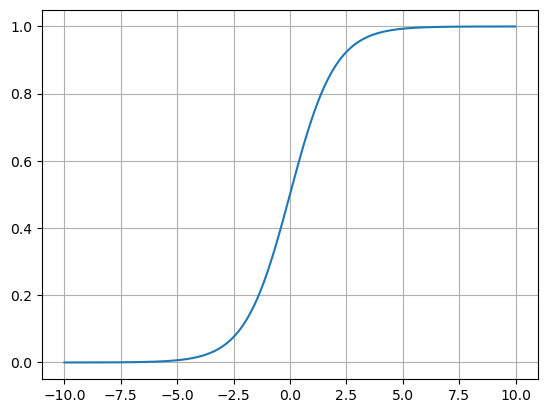

In [10]:
import matplotlib.pyplot as plt

plt.plot(z, g)
plt.grid()

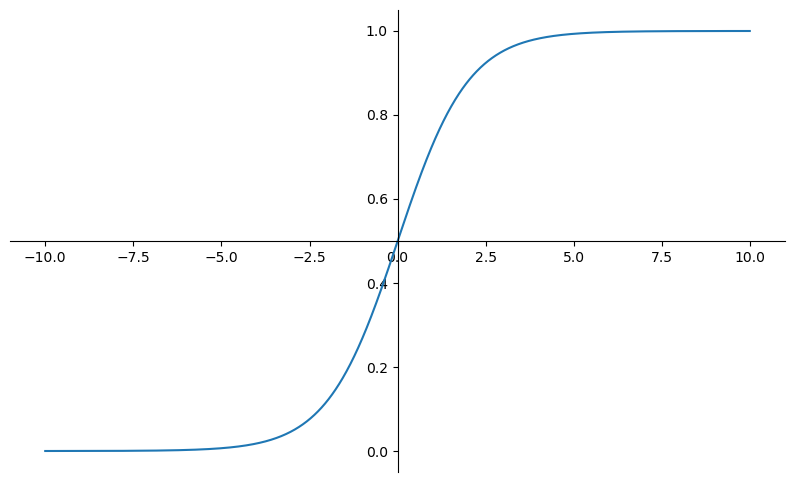

In [17]:
plt.figure(figsize=(10, 6))
ax = plt.gca() 
# .gca() : 현재 그림에 대한 Axes 객체를 반환하며, 이 객체를 통해 다양한 축과 그림 속성을 조작
ax.plot(z, g)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('center')
# .spines : 각 축의 top, bottom, left, right에 대한 설정을 변경
# .set_position(위치설정) : 
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none') 
# .set_color : 표의선 색 설정

### Logistic Regression
- Logistic Regression은 분류 문제이다
- 시그모이드 함수에다가 직선의 함수를 넣어서 결과를 판정하는 것이다

### Logistic Regression의 Cost Frnction

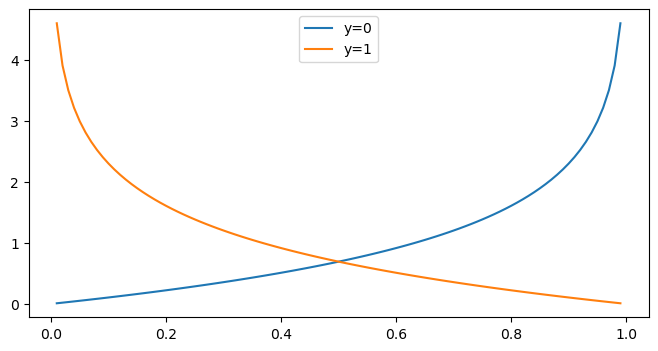

In [18]:
h = np.arange(0.01, 1, 0.01)

C0 = -np.log(1-h)
C1 = -np.log(h)

plt.figure(figsize=(8, 4))
plt.plot(h, C0, label = 'y=0')
plt.plot(h, C1, label = 'y=1')
plt.legend()

plt.show()

In [24]:
import pandas as pd

wine_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/wine.csv'

wine = pd.read_csv(wine_url, index_col=0)
# index_col=0 : csv파일을 불러올 시 새로운 컬럼(=unnamed : 0)을 생성시키지 않고 파일을 불러오겠다는 명령어
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


### 데이터 분리

In [25]:
from sklearn.model_selection import train_test_split

wine['taste'] = [1 if grade > 5 else 0 for grade in wine['quality']]

X = wine.drop(['taste', 'quality'], axis=1)
y = wine['taste']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### LogisticRegression 훈련 및 학습결과

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver='liblinear', random_state=13)
                        # solver = : 최적화 알고리즘 설정, 데이터가 적으면 'liblinear'로 설정
lr.fit(X_train, y_train)

y_pred_tr = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print('Train ACC : ', accuracy_score(y_train, y_pred_tr))
print('Train ACC : ', accuracy_score(y_test, y_pred_test))

Train ACC :  0.7425437752549547
Train ACC :  0.7438461538461538


### 파이프라인으로도 구축(StandardScaler() 및 LogisticRegression() 설정)

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

estimators = [('scaler', StandardScaler()),
              ('clf', LogisticRegression(solver='liblinear', random_state=13))]

pipe = Pipeline(estimators)
pipe.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(random_state=13, solver='liblinear'))])

In [28]:
y_pred_tr = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print('Train ACC : ', accuracy_score(y_train, y_pred_tr))
print('Train ACC : ', accuracy_score(y_test, y_pred_test))

Train ACC :  0.7444679622859341
Train ACC :  0.7469230769230769


##### 확인 결과 pipe가 교육 및 학습효과는 이전 단계보다 (미비하지만) 약간의 정확도가 상승했다

### DecisionTreeClassifier와 pipe 비교

In [30]:
from sklearn.tree import DecisionTreeClassifier

wine_tree = DecisionTreeClassifier(max_depth=2, random_state=13)
wine_tree.fit(X_train, y_train)

models = {'Logistic Regression' : pipe, 'decision tree' : wine_tree}

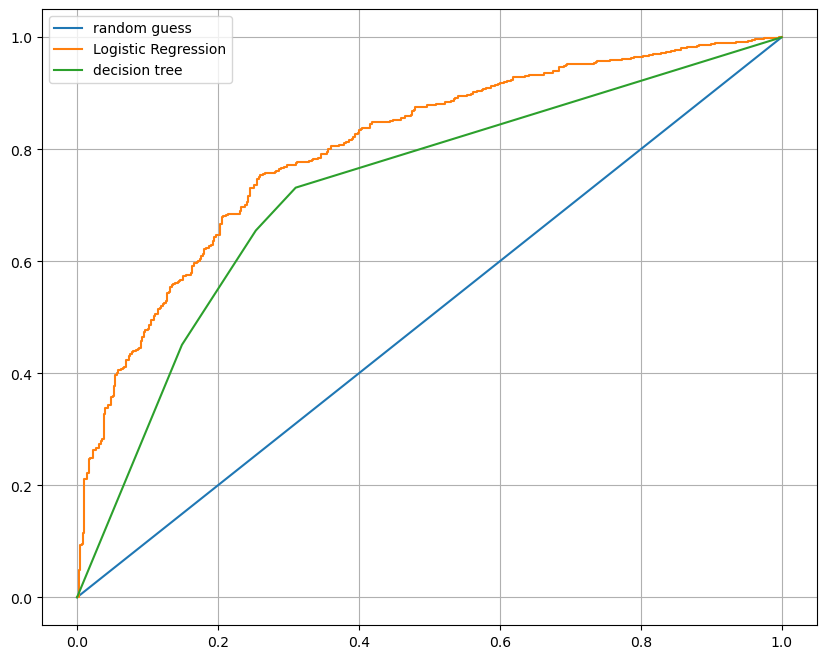

In [36]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], label = 'random guess')
for model_name, model in models.items():
                                # items() : 컬럼과 나머지 데이터를 리스트로 추출
                                # iterrows() : 인덱스와 나머지 데이터를 리스로 추출
    pred = model.predict_proba(X_test)[:, 1]
                # predict_proba() : 예측된 값이 속성(여기선 taste의 0 or 1)들 중 얼마나 비중을 차지하는지 보여주는 함수
                #.predict_proba(X_test)[:, 1] : 여기선 taste의 '1'일 확률들만의 값으로 가져온다는 설정
    fpr, tpr, thersholds = roc_curve(y_test, pred)
    # fpr = fall-out, tpr = recall
    plt.plot(fpr, tpr, label = model_name)

plt.grid()
plt.legend()
plt.show()

##### 상기와 같이 ROC curve를 통하여 좀 더 시각적으로 Logistic Regression 성능이 좀 더 좋았다는 것을 확인
- ROC curve 좌측 상단으로 갈수록(향할수록) 성능이 좋아진다

### PIMA 인디언 당뇨병 예측

In [43]:
import pandas as pd

PIMA_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/diabetes.csv'

PIMA = pd.read_csv(PIMA_url)
PIMA.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


- Pregnancies : 임신횟수, Glucose : 포도당 부하 검사 수치, BloodPressure : 혈압,
- SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값, Insulin : 혈청 인슐린, BMI : 체질량지수,
- DiabetesPedigreeFunction : 당뇨 내력 가중치 값, Age : 나이, Outcome : 클래스 결정, 당뇨 유무

In [44]:
PIMA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [46]:
PIMA = PIMA.astype('float')
PIMA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


### 상관관계 확인

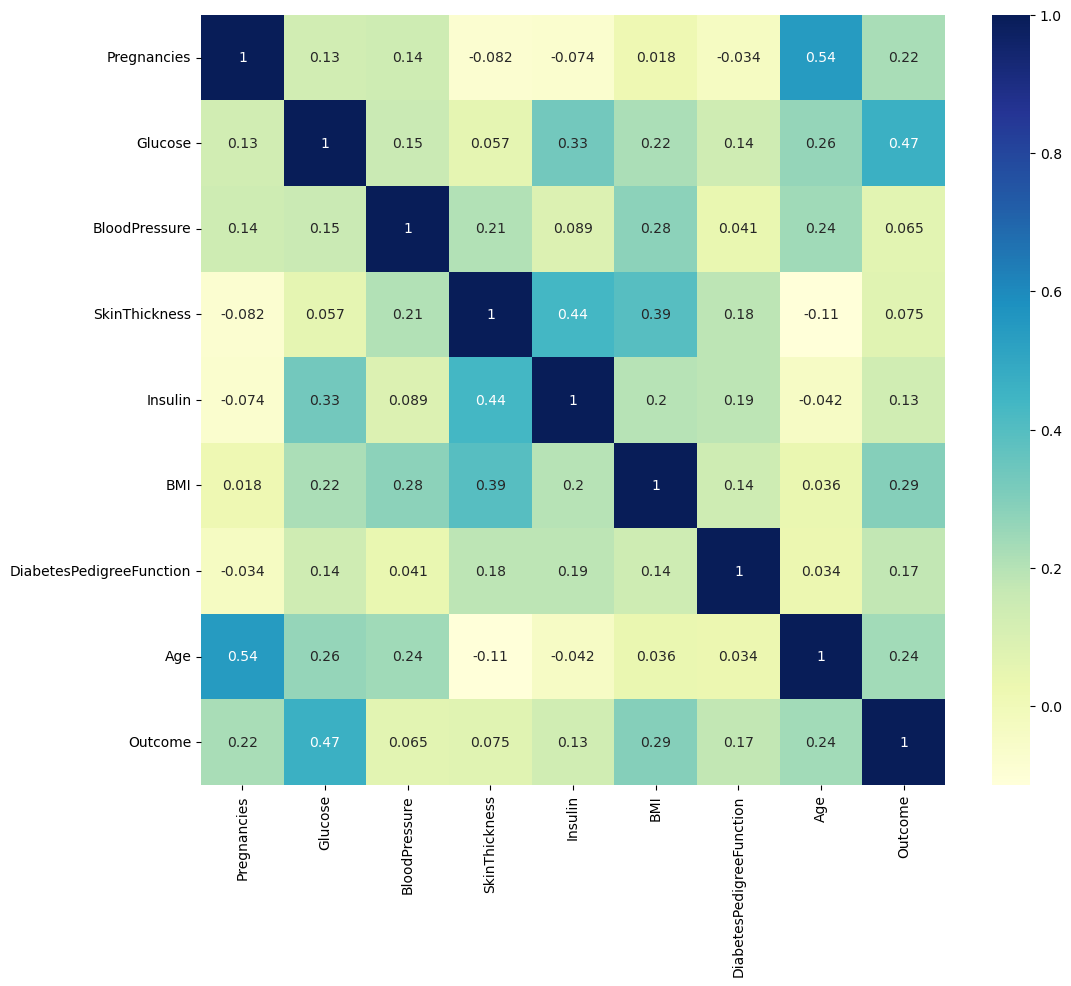

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(data = PIMA.corr(), annot=True, cmap='YlGnBu')
            # .corr() : 판다스 컬럼들의 상관관계를 보여주는 명령어
plt.show()

##### 상기 표에서는 Pregnancies, Glucose, BMI, Age 가 의미가 있어보인다

### 데이터 중에서 0 값이 존재한다
- 혈압의 경우 0으로 처리되어 있다 -> 잘못된 데이터가 포함되어 있다
- 현재 의학적 지식과 PIMA 인디언에 대한 추가 데이터가 없으므로 일단 평균값으로 대체한다
- 이는 옳은 전처리일수도 틀린 전처리일 수도 있으므로 각각의 상황(평균값을 적용/미적용)도 비교해 봐야된다
- 전문지식이 생긴다면 0값(null값)에 대한 처리를 많이 고민해봐야 된다 

In [54]:
(PIMA == 0).astype(int).sum()
# 각 컬럼별 값이 0인 총갯수(sum())  찾기

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [55]:
zero_featuer = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
PIMA[zero_featuer] = PIMA[zero_featuer].replace(0, PIMA[zero_featuer].mean())
                                       # replace(현재갑, 변경값)
(PIMA == 0).astype(int).sum()

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                     374
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

### 데이터 분리 및 파이프라인 구축 후 수치 확인

In [60]:
from sklearn.model_selection import train_test_split

X = PIMA.drop(['Outcome'], axis=1)
y = PIMA['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13,
                                                    stratify = y)
                                                    # stratify= : 나눈 데이터에 속성 값들을 동일한 비율로 맞춰주는 설정

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

estimators = [('scaler', StandardScaler()),
              ('clf', LogisticRegression(solver='liblinear', random_state=13))]

pipe_lr = Pipeline(estimators)
pipe_lr.fit(X_train, y_train)
pred = pipe_lr.predict(X_test)

In [63]:
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             roc_auc_score, f1_score)

print('Accuracy : ', accuracy_score(y_test, pred))
print('Recall : ', recall_score(y_test, pred))
print('Precision : ', precision_score(y_test, pred))
print('roc_auc_scoree : ',roc_auc_score(y_test, pred))
print('f1_score : ', f1_score(y_test, pred))

Accuracy :  0.7727272727272727
Recall :  0.6111111111111112
Precision :  0.7021276595744681
roc_auc_scoree :  0.7355555555555556
f1_score :  0.6534653465346535


In [65]:
X_train.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

### 다변수 방정식의 각 계수 값을 확인
- 현재 Traing, test의 8개의 X 변수 사용
- 해당 coef_는 선형 회귀에서 각각의 변수들에 곱해지는 값입니다. 다르게 말하면, 해당 변수가 출력에 얼마나 큰 영향을 미치는지를 표현하는 숫자입니다. 
- 따라서 해당 값의 절대값이 클 수록(음수로 커도 영향이 큰 점 생각해 주세요) 출력에 미치는 영향이 크다고 생각할 수 있는 것입니다!
- 예를 들면 6x + 10y 라면 coef_가 6, 10인 상황이라고 볼 수 있는데요, 이 때 출력 값에 미치는 영향이 x보다 y가 더 크다고 볼 수 있다는 것이죠!

In [68]:
pipe_lr['clf'].coef_ # .coef_ : 각 변수들의 계수를 확인시켜주는 명령어

array([[ 0.35426589,  1.20142444, -0.15840136,  0.03394658, -0.16286472,
         0.62040452,  0.36669356,  0.17195965]])

In [66]:
coeff = list(pipe_lr['clf'].coef_[0]) # [0] : 리스트 안의 리스트 구조이기에 0번째 리스트만 가져오도록 설정
labels = list(X_train.columns)

In [67]:
coeff

[0.3542658884412651,
 1.2014244425037581,
 -0.1584013553628671,
 0.03394657712929954,
 -0.16286471953988116,
 0.620404521989511,
 0.36669355795578745,
 0.17195965447035097]

In [70]:
labels

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

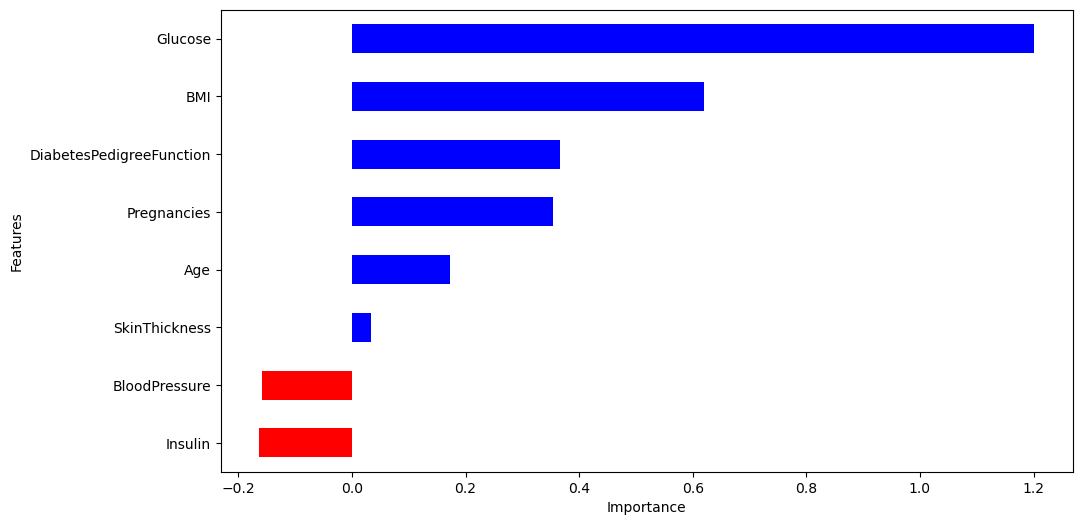

In [79]:
features = pd.DataFrame({'Features' : labels, 'importance' : coeff})
features.sort_values(by = ['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features['importance'].plot(kind='barh', figsize=(11, 6),
                            color = features['positive'].map({True : 'blue',
                                                             False : 'red'}))
plt.xlabel('Importance')
plt.show()